# Bank Failures Between 2000 and 2017

## The Data

The Federal Deposit Insurance Corporation (FDIC) is a government entity that was created in 1933 to restore consumer confidence in the banking system during the Great Depression. However, banks still fail. When this happens, the FDIC tries to find a successor to take over the failed banks accounts. Either way the consumer’s assets are insured up to a certain amount by the FDIC to discourage a run on the bank. The primary dataset from this report is from [the FDIC](https://www.fdic.gov/bank/individual/failed/banklist.html) and includes failed banks from after October 1, 2000. It is worth mentioning that  this list only includes banks that are insured and received by the FDIC. 

In [64]:
# %matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
import datetime
import scipy.stats as stats
import sklearn.linear_model as linear_model
import bokeh
import seaborn as sns
import math
import statistics
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter, LogColorMapper
from bokeh.palettes import Spectral5, Spectral6, Category20, Viridis256
from bokeh.palettes import Viridis6 as palette
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, show, output_file
from bokeh.models.ranges import FactorRange
from bokeh.core.properties import value
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
import folium
import os
import json

In [50]:
df = pd.read_csv('F:/Python/Final/banklist.csv', encoding='iso-8859-1')
df['Closing Date'] =  pd.to_datetime(df['Closing Date'], format='%d-%b-%y')
df['Updated Date'] =  pd.to_datetime(df['Updated Date'], format='%d-%b-%y')
df['Year'] = df['Closing Date'].astype(str).str[0:4]
df['Year'] = df['Year'].astype(int)

## Bank Failures and Time

### Failures Over Time

The following time series chart shows the number of bank failures over time. I have also included the median and mean as the recession data appears to be skewing the data. When we compare the number of failures per year to the median, it doesn't look like the number of bank failures is increasing over time.  In fact, looking at a [similar chart from FRED dating back to the 60s](https://fredblog.stlouisfed.org/2014/10/bank-failures/?utm_source=series_page&utm_medium=related_content&utm_term=related_resources&utm_campaign=fredblog), our data does not look anomalous at all . There is clearly a correlation between recession years and the number of failed banks in that year. The most recent recession didn’t generate anywhere the largest number of failed banks.

In [3]:
output_notebook()

source = pd.value_counts(df['Year'].values, sort=False)

plot = figure(title="Bank Failures Over Time", tools=['pan'])
plot.xaxis.axis_label = 'Year'
plot.yaxis.axis_label = 'Number of Bank Failures'

circle = plot.circle(source.index, source.values, fill_color="white", size=8)
line1 = plot.line(source.index, source.values, line_width=2, color='navy', legend='Number of Bank Failures')
line2 = plot.line(source.index, np.mean(source.values), line_width=2,  color='red', legend='Mean', line_dash='dashed')
line3 = plot.line(source.index, np.median(source.values), line_width=2,  color='green', legend='Median', line_dash='dotted')

hover1 = HoverTool(
    tooltips=[
        ( 'Year','$x{0}'),
        ( 'Bank Failures','@y{0}'),
    ], renderers=[circle],
)

hover2 = HoverTool(
    tooltips=[
        ( 'Mean','$y'),
    ], renderers=[line2],
)

hover3 = HoverTool(
    tooltips=[
        ( 'Median','$y'),
    ], renderers=[line3],
)
plot.add_tools(hover1)
plot.add_tools(hover2)
plot.add_tools(hover3)

plot.legend.location = "top_left"
show(plot)

Loading BokehJS ...

### Failures by Month

Additionally, we can look at the number of banks failures that occur during each month over the time period. The following chart is a pie graph of bank failures by the closure month. Standard banking quarters are January, February, and March (Q1); April, May, and June (Q2); July, August, and September (Q3); and October, November, and December (Q4). We can see clearly from the graph that instances of closure are more prevalent in the first month of every quarter (i.e. January, April, July, October).

In [48]:
output_notebook()

months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]
failures = [51, 44, 40, 59, 43, 36, 74, 41, 38, 59, 35, 35]
x_pos = [2] * 12
y_pos = [2] * 12
starts = [math.radians(i * 30) for i in range(12)]
ends = [x + math.radians(30) for x in starts]
max_fails = max(failures)
radii = [x / max_fails * 1.8 for x in failures]
colors = Category20[12]
TOOLS = "hover"

failure_source = ColumnDataSource(data=dict(months=months, failures=failures,x=x_pos, y=y_pos, radius=radii,
                                            start_angle=starts, end_angle=ends,color=colors))

p = figure(title="Bank Failures Per Month", plot_width=600, plot_height=600, x_range=(0, 4), y_range=(0, 4), tools = TOOLS)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("Month", "@months"),("Failures", "@failures")]

p.wedge(x='x', y='y', radius='radius', start_angle='start_angle', end_angle='end_angle',
        color='color', source=failure_source, legend='months')

p.title.text_font_size = "25px"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False

show(p)

Loading BokehJS ...

## Acquisitions

### Acquiring Institutions by Bank Location

It is worth studying patterns in acquistitions of failed banks. The following bar chart shows the top 10 aquiring institutions. I have further segmented the bars into the location of the failed bank. The chart shows that more baks failed to be acquired more often than the number of failed banks any one insitution acquired. It also looks as though the top aquiring were often absorbing banks in Georgia. We will examine patterns between bank failures and states later. First, let's look at the banks that were reported as having no acquirer.

<Figure size 1760x1600 with 0 Axes>

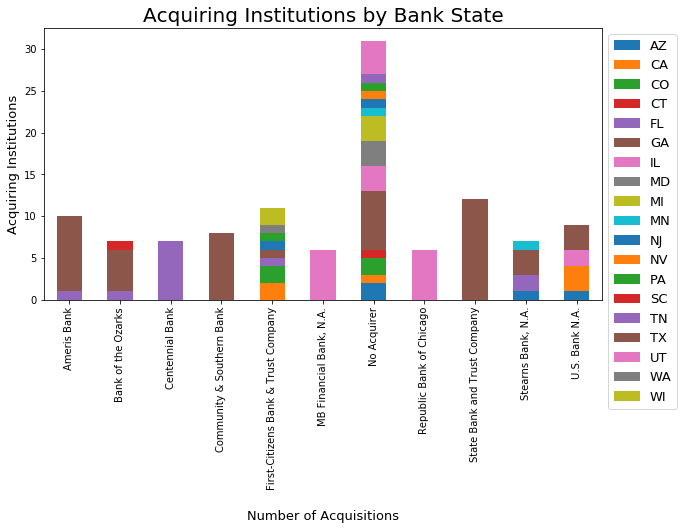

In [45]:
data = pd.value_counts(df['Acquiring Institution'].values, sort=True)[0:11]
df1 = df[['Acquiring Institution', 'ST']]
df1 = pd.crosstab(index=df1['Acquiring Institution'], columns=df1['ST'])

institution = []
for x in data.index:
    institution.append(x)
df1 = df1[df1.index.isin(institution)]
df1.loc['Total']= df1.sum()

df1.drop(["AL", "AR", "HI", "IA", "ID", "IN",  "KS", "KY", "LA", "MA", "MO",  "MS", "NC", "NE", "NH", "NM", 
          "NY", "OH", "OK", "OR", "PR", "SD", "VA", "WV",  "WY"], axis=1, inplace=True)
df1 = df1.drop("Total", axis=0)

states = []
for x in df1.columns:
    states.append(x)

fig = plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
df1.plot(kind='bar', stacked=True)
plt.title('Acquiring Institutions by Bank Location', fontsize=20)
plt.xlabel('Number of Acquisitions', fontsize=13, labelpad=20)
plt.ylabel('Acquiring Institutions', fontsize=13)
plt.legend(bbox_to_anchor=(1,1), prop={'size': 13})
plt.show()

### Unacquired Banks

When we look at the unacquired banks segmented by year of failure and state, we see some similar patterns. The year of failures correspond with the Great Recession. Further, Georgia is also leading the number of unacquired banks. Let's take a closer look at bank failures across the states.

In [95]:
df2 = df.loc[df['Acquiring Institution'] == 'No Acquirer']

d1 = pd.value_counts(df2['ST'].values, sort=True).reset_index()
d1.columns = ['State', 'Counts']
d2 = pd.value_counts(df2['Year'].values, sort=False)

s1.xaxis.axis_label = 'State'
s1.yaxis.axis_label = 'Unacquired Banks'
s2.xaxis.axis_label = 'Year'
s2.yaxis.axis_label = 'Unacquired Banks'
color1 = Category20[14]
color2 = Category20[7]

s1 = figure(x_range=d1['State'].values, plot_height=250, plot_width=480, title="Unacquired Banks by State", tools=['pan'])
s2 = figure(plot_height=250, plot_width=480, title="Unacquired Banks by Year", tools=['pan'])

s1.vbar(x=d1['State'], top=d1['Counts'], width=0.9, color=color1)

s2.vbar(x=d2.index, top=d2.values, width=0.9, color=color2)

hover1 = HoverTool(
    tooltips=[
        ( 'State','@x'),
    ('Unacquired Banks','@top')]
)

hover2 = HoverTool(
    tooltips=[
        ( 'Year','@x'),
    ('Unacquired Banks','@top')]
)
s1.add_tools(hover1)
s1.xaxis.major_label_orientation = 1.2
s2.add_tools(hover2)
s2.xaxis.major_label_orientation = 1.2
s2.xaxis.ticker = [i for i in range(2000, 2018)]

grid = gridplot([s1, s2], ncols=2, plot_width=480, plot_height=250)
show(grid)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='3a143e2a-a7bd-4952-bd12-b07468902341', ...)]


## Bank Failure By State

In [90]:
data = pd.value_counts(df['ST'].values, sort=True).reset_index()
data.columns = ['State', 'BankFailures']
data.describe()

,BankFailures
count,44.000000
mean,12.613636
std,19.755736
min,1.000000
25%,2.750000
50%,7.000000
75%,11.250000
max,93.000000


In [91]:
output_notebook()

p1 = figure(x_range=data['State'].values, plot_height=250, plot_width=900, title="Failures by State",
           tools=['pan'])

p1.vbar(x=data['State'], top=data['BankFailures'], width=0.8)

hover = HoverTool(
    tooltips=[
        ( 'State','@x'),
    ('Number of Failures','@top')]
)
p1.add_tools(hover)
p1.xaxis.major_label_orientation = 1.2
p1.xaxis.axis_label = 'State'
p1.yaxis.axis_label = 'Number of Bank Failures'

show(p1)

Loading BokehJS ...

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='3a143e2a-a7bd-4952-bd12-b07468902341', ...)]


There is a clear pattern of failure rate by state. This could be due to population size, regulation, number of existing banks, etc. The median number of failed banks in a state with failed banks is 7. However, a few states were considerably higher. The data that we currently have is actually less severe than reality, as there are states that didn't have any bank failures during the period and are not reflected in the list of failed banks. Let's add them back into the data and have another look.

In [92]:
state_data = pd.value_counts(df['ST'].values, sort=False)
state_data = state_data.reset_index()
state_data.columns = ['State', 'BankFailures']

State = ["AK", "DE", "ME", "MT", "ND", "VT", "RI"]
BankFailures = [0 for i in range(0, 7)]

state = pd.DataFrame(
    {'State': State,
     'BankFailures': BankFailures,
    })

state_data = pd.concat([state, state_data], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=True,
          copy=False)

state_data.describe()

,BankFailures
count,51.000000
mean,10.882353
std,18.837884
min,0.000000
25%,1.500000
50%,5.000000
75%,10.000000
max,93.000000


In [96]:
state_geo = os.path.join('F:/Python/Final/', 'us-states.json')

map = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'BankFailures'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Bank Failures'
).add_to(map)

folium.LayerControl().add_to(map)

map

The distribution of bank failures across states is so skewed that it is rather hard to read the choropleth. However, we can see that a couple of states had much higher frequency of failures than the norm. These appear to be outliers, but we'll use the IQR to be sure. I did not bother showing data below the lower bound, as the data naturally has a lower bound.

In [94]:
sorted(state_data)
q1, q3= np.percentile(state_data['BankFailures'],[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * q1)
upper_bound = q3 + (1.5 * q3)

print(upper_bound)
print(state_data[state_data['BankFailures'] > upper_bound])

25.0
   State  BankFailures
19    CA            41
20    GA            93
41    FL            75
43    IL            69


The upper bound is 25, so California, Georgia, Florida, and Illinois are clearly outliers. With the exception of California, the outlier states are in a similar geographic region. However, they make up 4 different Federal Reserve districts. Additionally, none of the states had a particularly high [ratio of bank per 100,000 people](https://ilsr.org/map-shows-how-well-the-bank-of-north-dakota-works/).

## Concluding Remarks

There were quite a few patterns seen throughout the failed bank data. There is a very clear pattern between recessions and number of failures. Other than that, the years appear to be correlated with bank failures as they are with each other. Bank failures are not trending upward or downward. Furthermore, there seemed to be a correlation with months and number of closing banks, it was not very insightful, as the months correspond to quarters. While looking at bank acquisitions, we saw that the unacquired bank's closing dates were similar to the trends over time. Additionally, there were interesting patterns occuring between states. When we explored the state data further, it became apparent that there were a could states that did very poorly during the period. I would want to further investigate the [effect of the recession on these states](http://time.com/4133963/us-census-poverty-income-great-recession/), [change in population from 2000-2017](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk), other [various demographic trends](https://www.fcnl.org/updates/top-10-poorest-states-in-the-u-s-1630), and [regulations in the state](https://www.mercatus.org/publications/regulation/comparing-regulations-across-us-states). I do think that it would be meaningful to also investigate percentage of banks in the state that failed, rather than just raw numbers. 